In [1]:
from torch import nn, tensor
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
#%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
class OnlineCounterexample(nn.Module):
    def __init__(self,C,initial_w = 1.0): 
        super(OnlineCounterexample, self).__init__()
        self.C = C 
        self.w = nn.Parameter(tensor([initial_w]))

    def forward(self, x,t: int):
        if t%3 == 1:
            return self.C * x *self.w 
        else: 
            return -x*self.w
        

def calculate_optimal_point(fseq: OnlineCounterexample, T: int, domain: np.linspace):
    """
    Calculates the optimal point and value for a given function sequence over a specified domain.

    Args:
        fseq (OnlineCounterexample): The function sequence.
        T (int): The number of rounds.
        domain (np.linspace): The domain over which to search for the optimal point.

    Returns:
        tuple: A tuple containing the optimal point and the corresponding optimal value.
    """
    #get optimal point in domain and value 
    fseq.w.data = tensor([1.0]) #reset w to 1.0 for testing x values 
    optimal_point = 0
    optimal_value = np.inf 

    for point in domain: 
        running_value = 0
        #sum over rounds t = 1 to T 
        for t in range(T): 
            running_value += fseq(tensor(point),t).item() 
        if running_value < optimal_value:
            optimal_value = running_value 
            optimal_point = point 

    return optimal_point, optimal_value

In [3]:
domain = np.linspace(-1,1,100)
C = 3 
beta_1 = 0 
beta_2 = 1/(1+C**2) #note beta_1^2 < sqrt(beta_2) in Adam theorem 4.1 
betas = [beta_1,beta_2] #Adam parameters 
T = 40 #number of rounds 
function_seq = OnlineCounterexample(C,initial_w = 1.0) #initialize function sequence 
optimizer = optim.Adam(function_seq.parameters(), betas = betas) #initialize optimizer
optimizer = optim.Adam(function_seq.parameters()) #initialize optimizer
optimized_seq = np.zeros(T) 



for t in range(T): 
    optimizer.zero_grad()
    loss = function_seq(tensor(1.0),t)
    loss.backward()
    optimizer.step()
    #bound back to 1 if above 
    if function_seq.w.item() > 1: 
        function_seq.w.data = tensor([1.0])

    optimized_seq[t] = function_seq.w.item()

In [4]:
print('Optimized sequence: ',optimized_seq[:5])

Optimized sequence:  [1.         0.99950582 0.99933434 0.99936777 0.99903172]


Note weight decay for AdamW above 20% does indeed get better solutions than Adam, however this is because $x=0$ is a better solution than $x>0$, and if the problem were reversed, then AdamW could perform worse.  

In [5]:
T_values = range(10,10000,10)

regret_per_values = np.zeros([3,len(T_values)])
C=4
beta_1 = 0 
beta_2 = 1/(1+C**2) #note beta_1^2 < sqrt(beta_2) in Adam theorem 4.1 
betas = [beta_1,beta_2] #Adam parameters 
opt_point = tensor(-1.0)

base_sequence = OnlineCounterexample(C,initial_w = 1.0)
function_seq = OnlineCounterexample(C,initial_w = 1.0)  #initialize function sequence 
function_seqW = OnlineCounterexample(C,initial_w = 1.0) 
function_seqS = OnlineCounterexample(C,initial_w = 1.0)
function_seqlist = [function_seq,function_seqW,function_seqS]

optimizer_adam = optim.Adam(function_seq.parameters(),betas=betas) #initialize optimizer
optimizer_adamW = optim.AdamW(function_seqW.parameters(),betas=betas)   #Try weight_decay>.2 to see the difference!
optimizer_sgd = optim.SGD(function_seqS.parameters()) 
optimizers = [optimizer_adam,optimizer_adamW,optimizer_sgd]

optimized_seq = np.zeros([3,len(T_values)]) 
#opt_point,opt_value = calculate_optimal_point(function_seq,T,domain)
running_regret = np.zeros(3)
T_prev = 1
opt_value = 0


for T in T_values: 
    for t in range(T_prev,T+1): 
        opt_value += base_sequence(opt_point,t).item()   #same for all optimizers
        for i in range(3):
            optimizers[i].zero_grad()
            loss = function_seqlist[i](tensor(1.0),t)
            running_regret[i] += loss.item() 
            
            loss.backward()
            optimizers[i].step()
            #bound back to 1 if above 
            if function_seqlist[i].w.item() > 1: 
                function_seqlist[i].w.data = tensor([1.0])
            
            #bound up to -1 if below
            if function_seqlist[i].w.item() < -1: 
                function_seqlist[i].w.data = tensor([-1.0])

            optimized_seq[i,(T-10)//10] = function_seqlist[i].w.item()
            regret_per_values[i,(T-10)//10] = (running_regret[i] - opt_value)/(T)
            
    T_prev = T+1

    

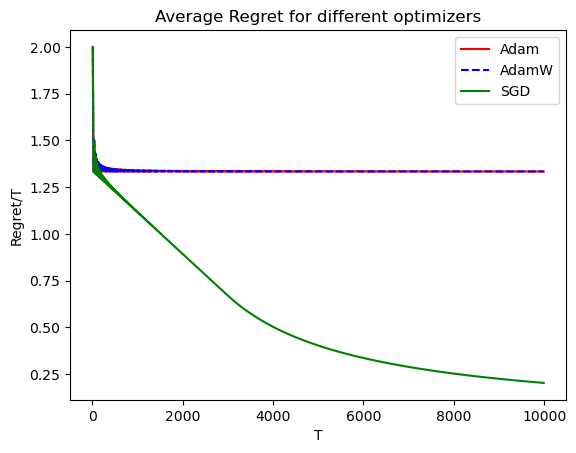

In [6]:
colors = ['red', 'blue', 'green']
labels = ['Adam', 'AdamW', 'SGD']
linestyles = ['-', '--', '-']  # Add the linestyles for each line

for i in range(3):
    plt.plot(T_values, regret_per_values[i], color=colors[i], linestyle=linestyles[i], label=labels[i])  # Use the linestyle parameter


plt.xlabel('T')
plt.ylabel('Regret/T')
plt.title('Average Regret for different optimizers')
plt.legend()
plt.savefig('average_regret.png')


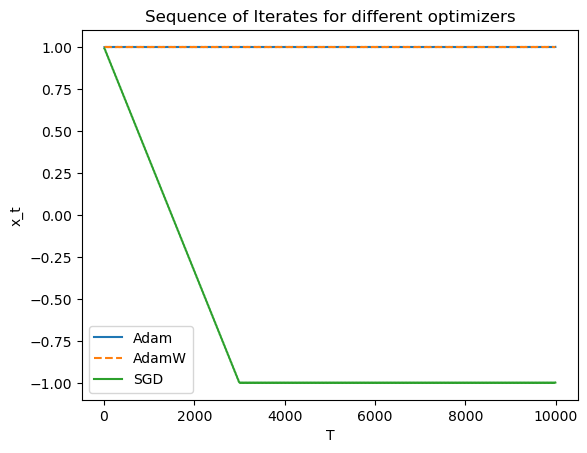

In [7]:
#plot the optimized sequence for each optimizer
plt.plot(T_values,optimized_seq[0], label='Adam')
plt.plot(T_values,optimized_seq[1],label='AdamW',linestyle='--')
plt.plot(T_values,optimized_seq[2],label='SGD')
plt.xlabel('T')
plt.ylabel('x_t')
plt.title('Sequence of Iterates for different optimizers')
plt.legend()
plt.savefig('sequence_of_iterates.png')

In [8]:
#variance of each sequence 
print('Variance of Adam: ',np.var(optimized_seq[0]))
print('Variance of AdamW: ',np.var(optimized_seq[1]))
print('Variance of SGD: ',np.var(optimized_seq[2]))

Variance of Adam:  1.8758278012379984e-07
Variance of AdamW:  1.8958264528616078e-07
Variance of SGD:  0.3076974354208121


In [9]:
#display minimal values of optimized sequence 
print('Minimal value of Adam: ',np.min(optimized_seq[0]))
print('Minimal value of AdamW: ',np.min(optimized_seq[1]))
print('Minimal value of SGD: ',np.min(optimized_seq[2]))

Minimal value of Adam:  0.9989713430404663
Minimal value of AdamW:  0.998961329460144
Minimal value of SGD:  -1.0
